# Distance Feature Engineering and Selection for Location Choice Model

In this notebook, we analyze the distance information to be used for our location choice model. In particular, we do some feature engineering to test various input formats for the random forest classifier. After this, we identify the features which we wish to keep.

### Metrics

The performance metrics we consider are:
- Accuracy: The accuracy of the model as calculated by `sklearn`, also the micro precision/recall/F-1 score  
- PRF1 Mac: The macro precision, recall, and F-1 score  
- Matthews: The Matthews Correlation Coefficient (MCC)  
- Average Probability of Observations (APO): The average predicted probabilities produced by the classifier of observed campus choices for the testing data.


### Load Data

First, let's load our data.

In [1]:
import pandas as pd

df = pd.read_csv('../Data/SMTO_2015/SMTO_2015_Complete_Input.csv')
df.head()

,Campus,Level,Status,Mode_Actual,Gender,Licence,Work,Age,HomeZone,Family,...,Domestic.OC,Admission_Avg.SG,Admission_Avg.SC,Admission_Avg.MI,Admission_Avg.YK,Admission_Avg.YG,Admission_Avg.RY,Admission_Avg.OC,Exp_Segment,Exp_Level
0,Scarborough (UTSC),UG,FT,Transit Bus,Female,0,Unknown,20,261,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.383705,0.383705
1,Downtown Toronto (St. George),Grad,FT,Walk,Female,1,Unknown,25,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085
2,Downtown Toronto (St. George),UG,FT,Transit Bus,Female,1,Unknown,23,3714,1,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
3,Downtown Toronto (St. George),UG,FT,Walk,Male,1,Unknown,20,74,0,...,0.8998,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.919270,0.919270
4,Downtown Toronto (St. George),Grad,FT,Walk,Male,1,Unknown,27,71,0,...,0.6786,0.893,0.841,0.83,0.817,0.817,0.84,0.824,0.986085,0.986085


### Feature Engineering

There are several formats in which we can pass distance information into the random forest model. These include:

- Standard: Columns containing the distances from each students' home zone to each campus zone  
- Closest labels: Columns n from 0 to 6 containing the label of the campus that is nth closest to the students' home zone  
- Closest distances: Columns n from 0 to 6 containing the distance to the campus that is nth closest to the students' home zone 

Note that the closest labels format are one-hot-encoded using `get_dummies()`.

In [2]:
y = df['School_Codes']

closest_labels = pd.DataFrame(df.iloc[:, 17:24].apply(lambda x: x.nsmallest(7).index.tolist(), axis=1).tolist(), index=df.index)
closest_distances = pd.DataFrame(df.iloc[:, 17:24].apply(lambda x: x.nsmallest(7).tolist(), axis=1).tolist(), index=df.index)
x = pd.concat((df.iloc[:, 17:24], closest_labels, closest_distances), axis=1)
x = pd.get_dummies(x)
x.columns

Index([  'Dist.SG',   'Dist.SC',   'Dist.MI',   'Dist.YK',   'Dist.YG',
         'Dist.RY',   'Dist.OC',           0,           1,           2,
                 3,           4,           5,           6, '0_Dist.MI',
       '0_Dist.OC', '0_Dist.RY', '0_Dist.SC', '0_Dist.SG', '0_Dist.YG',
       '0_Dist.YK', '1_Dist.MI', '1_Dist.OC', '1_Dist.RY', '1_Dist.SC',
       '1_Dist.SG', '1_Dist.YG', '1_Dist.YK', '2_Dist.MI', '2_Dist.OC',
       '2_Dist.RY', '2_Dist.SC', '2_Dist.SG', '2_Dist.YG', '2_Dist.YK',
       '3_Dist.MI', '3_Dist.OC', '3_Dist.RY', '3_Dist.SC', '3_Dist.SG',
       '3_Dist.YG', '3_Dist.YK', '4_Dist.MI', '4_Dist.OC', '4_Dist.RY',
       '4_Dist.SC', '4_Dist.SG', '4_Dist.YG', '4_Dist.YK', '5_Dist.MI',
       '5_Dist.OC', '5_Dist.RY', '5_Dist.SC', '5_Dist.YG', '5_Dist.YK',
       '6_Dist.MI', '6_Dist.SC'],
      dtype='object')

### Running Model

Now, let us run the model with all of the extracted features.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

rf = RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy\t", rf.score(X_test, y_test)) # Acc
print("PRF1 Mac\t", precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3]) # Rec = Bal Acc
print("Matthews\t", matthews_corrcoef(y_test, y_pred))

Accuracy	 0.44042746703046837
PRF1 Mac	 (0.300889732666631, 0.2832393705284428, 0.28456064289171673)
Matthews	 0.21690263950229433


### Feature Selection

Now, we can take a look at which features were most important. We analyze two such metrics:

- FeatImportance: The impurity-based feature importances  
- PermImportance: The permutation importance of each feature, averaged over 5 trials  

Including the permutation importance acts as a way to mitigate the bias towards high-cardinality features from the impourity-based feature importance.

In [4]:
features = pd.DataFrame(index = X_test.columns)
features['FeatImportance'] = rf.feature_importances_

result = permutation_importance(rf, X_train, y_train)
features['PermImportance'] = result.importances_mean

features.head()

,FeatImportance,PermImportance
Dist.SG,0.080061,0.002144
Dist.SC,0.058247,0.003742
Dist.MI,0.055050,0.002631
Dist.YK,0.062249,0.004249
Dist.YG,0.049286,0.001988


We've generated a dataframe containing the importance metrics for each feature. Let's see which features were identified as most important by each metric.

In [5]:
print(sorted(list(map(str, list(features['PermImportance'].sort_values(ascending=False)[:14].index)))))
print(sorted(list(map(str, list(features['FeatImportance'].sort_values(ascending=False)[:14].index)))))

['0', '0_Dist.MI', '1', '2', '4', '5', '5_Dist.YG', '6', 'Dist.MI', 'Dist.OC', 'Dist.SC', 'Dist.SG', 'Dist.YG', 'Dist.YK']
['0', '1', '2', '3', '4', '5', '6', 'Dist.MI', 'Dist.OC', 'Dist.RY', 'Dist.SC', 'Dist.SG', 'Dist.YG', 'Dist.YK']


From this we see that both metrics mostly agree on which features are most important. These are the standard distances and closest distances.

### Verification

To verify this finding, we can use `sklearn`'s `SelectFromModel`. Notice that these produce the same results.

In [6]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)
print(sorted(list(map(str, list(X_train.columns[(sel.get_support())])))))

['0', '1', '2', '3', '4', '5', '6', 'Dist.MI', 'Dist.OC', 'Dist.RY', 'Dist.SC', 'Dist.SG', 'Dist.YG', 'Dist.YK']


We also compare the results using all the extracted features with the results using only the selected ones, and using only standard distances (the benchmark model).

In [7]:
from statistics import stdev
def average(l):
    return sum(l) / len(l)


schools = list(rf.classes_)

for x_temp, name in ((x.iloc[:, :7], "Benchmark"), (x.iloc[:, :14], "Selected"), (x, "Full")):
    acc = []
    prec = []
    rec = []
    f_1 = []
    mcc = []
    apo = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y, test_size=0.3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)        
        acc.append(rf.score(X_test, y_test))
        p, r, f = precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3]
        prec.append(p)
        rec.append(r)
        f_1.append(f)
        mcc.append(matthews_corrcoef(y_test, y_pred))
        probs = rf.predict_proba(X_test)
        results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
        apo.append(results.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())
        
    
    print("Results for " + name + " model:")
    print("Accuracy\t", average(acc), "\t", stdev(acc))
    print("Prec Mac\t", average(prec), "\t", stdev(prec))
    print("Rec  Mac\t", average(rec), "\t", stdev(rec))
    print("F-1  Mac\t", average(f_1), "\t", stdev(f_1))
    print("Matthews\t", average(mcc), "\t", stdev(mcc))
    print("Ave Prob\t", average(apo), "\t", stdev(apo))
    print()

Results for Benchmark model:
Accuracy	 0.45707139608913144 	 0.008947825758220878
Prec Mac	 0.3519338161756017 	 0.014976379590690292
Rec  Mac	 0.30368987387958957 	 0.009472603920319105
F-1  Mac	 0.30880716066523134 	 0.00888279138308434
Matthews	 0.23897983779096724 	 0.010209818205008355
Ave Prob	 0.3838532649707296 	 0.005215414009027893

Results for Selected model:
Accuracy	 0.4585266030013643 	 0.006702518228375103
Prec Mac	 0.3299466906505214 	 0.012385275681413737
Rec  Mac	 0.3008670592734318 	 0.006329569263597258
F-1  Mac	 0.30383275229164525 	 0.005249144471120022
Matthews	 0.24066247969023488 	 0.008996358785125535
Ave Prob	 0.3842977818816484 	 0.003563402116599776

Results for Full model:
Accuracy	 0.46241473396998634 	 0.005213753292299161
Prec Mac	 0.348294509768294 	 0.016333606780147492
Rec  Mac	 0.30645048788823426 	 0.008059998548805321
F-1  Mac	 0.3107704175123465 	 0.007635184833355074
Matthews	 0.24462845346269058 	 0.008466788652553535
Ave Prob	 0.38720093994707

From these results, we see that the differences between each model are statistically insignificant (especially when considering the standard deviations of the results). The fact that even the full model offers only a marginal improvement over the benchmark model suggest potential overfitting in the training process.

### Feature Selection Part II

To further refine this feature selection process, let us look at how accuracy changes for different numbers of campuses included.

In [8]:
accs = []
apos = []
for i in range(8):
    x_temp = x.iloc[:, :7+i]
    name = str(i) + " Closest"
    acc = []
    prec = []
    rec = []
    f_1 = []
    mcc = []
    apo = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y, test_size=0.3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)        
        acc.append(rf.score(X_test, y_test))
        p, r, f = precision_recall_fscore_support(y_test, y_pred, average = 'macro')[:3]
        prec.append(p)
        rec.append(r)
        f_1.append(f)
        mcc.append(matthews_corrcoef(y_test, y_pred))
        probs = rf.predict_proba(X_test)
        results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
        apo.append(results.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())    
    accs.append(average(acc))
    apos.append(average(apo))    
    print("Results for " + name + " model:")
    print("Accuracy\t", average(acc), "\t", stdev(acc))
    print("Prec Mac\t", average(prec), "\t", stdev(prec))
    print("Rec  Mac\t", average(rec), "\t", stdev(rec))
    print("F-1  Mac\t", average(f_1), "\t", stdev(f_1))
    print("Matthews\t", average(mcc), "\t", stdev(mcc))
    print("Ave Prob\t", average(apo), "\t", stdev(apo))
    print()

Results for 0 Closest model:
Accuracy	 0.4546157344247385 	 0.005689149651946227
Prec Mac	 0.33423638646214854 	 0.01149413394621569
Rec  Mac	 0.2975913257611065 	 0.007708319132936965
F-1  Mac	 0.3028067915863597 	 0.0071529236106998495
Matthews	 0.23445189763314445 	 0.006764361625970862
Ave Prob	 0.38391160167845706 	 0.0038412193378259264

Results for 1 Closest model:
Accuracy	 0.4573442473851751 	 0.006321436699953601
Prec Mac	 0.3419609044784858 	 0.011481268463145558
Rec  Mac	 0.3026091608468537 	 0.004956376272989158
F-1  Mac	 0.30628805657141805 	 0.005273409983049447
Matthews	 0.24031454813684322 	 0.008544085743467872
Ave Prob	 0.38461206077325116 	 0.0025445089896396233

Results for 2 Closest model:
Accuracy	 0.45884492951341516 	 0.00754882497983248
Prec Mac	 0.3361171522902765 	 0.013644171507394057
Rec  Mac	 0.300269601665625 	 0.008907840080187928
F-1  Mac	 0.30521246557552983 	 0.009089731814799528
Matthews	 0.23943266102842337 	 0.008348982813319633
Ave Prob	 0.386103

Let's plot these results.

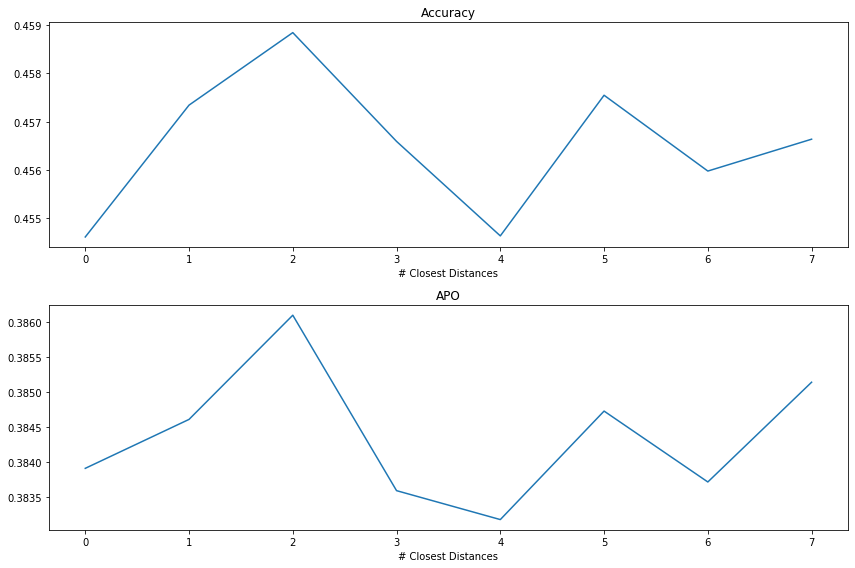

In [9]:
import matplotlib.pyplot as plt
plt.subplots(2, 1, figsize=(12, 8))
plot_info = (('Accuracy', list(range(8)), accs), ('APO', list(range(8)), apos))
for i in range(len(plot_info)):
    plt.subplot(2, 1, i+1)
    plt.title(plot_info[i][0])
    plt.xlabel('# Closest Distances')
    plt.tight_layout()
    plt.plot(plot_info[i][1], plot_info[i][2])
plt.show()

It seems that while the effectiveness of the model fluctuates for different numbers of labels included, these trends are not predictable and hardly significant.

### Feature Engineering Part II

One last approach to test is passing in the original Home Zones. While this variable should not really be treated as numeric, zones that are nearby usually have similar numbers. Thus, the random forest alrgorithm might recognize regional trends without making use of distances to specific campuses specifically.

To reduce the likelihood of overfitting (i.e. "memorizing the data" rather than understanding relationships within it), we can try dividing the HomeZone column by various numbers, essentially grouping adjacent zones together in the analysis. This would make the model more useful for zones that were not in the training data.

In [10]:
denoms = list(range(1, 26)) + list(range(30, 210, 10)) + list(range(300, 1100, 100))
denoms_for_plot = [item for item in denoms for i in range(5)]
acc = []
apo = []
for j in denoms:
    x_temp = (df['HomeZone'] / j).astype(int).values.reshape(-1, 1)
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(x_temp, y, test_size=0.3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)        
        acc.append(rf.score(X_test, y_test))
        probs = rf.predict_proba(X_test)
        results = pd.concat((y_test.reset_index(drop=True), pd.DataFrame(probs)), axis=1)
        apo.append(results.apply(lambda z: z[schools.index(z.School_Codes)], axis=1).mean())

Once again, let's plot the results.

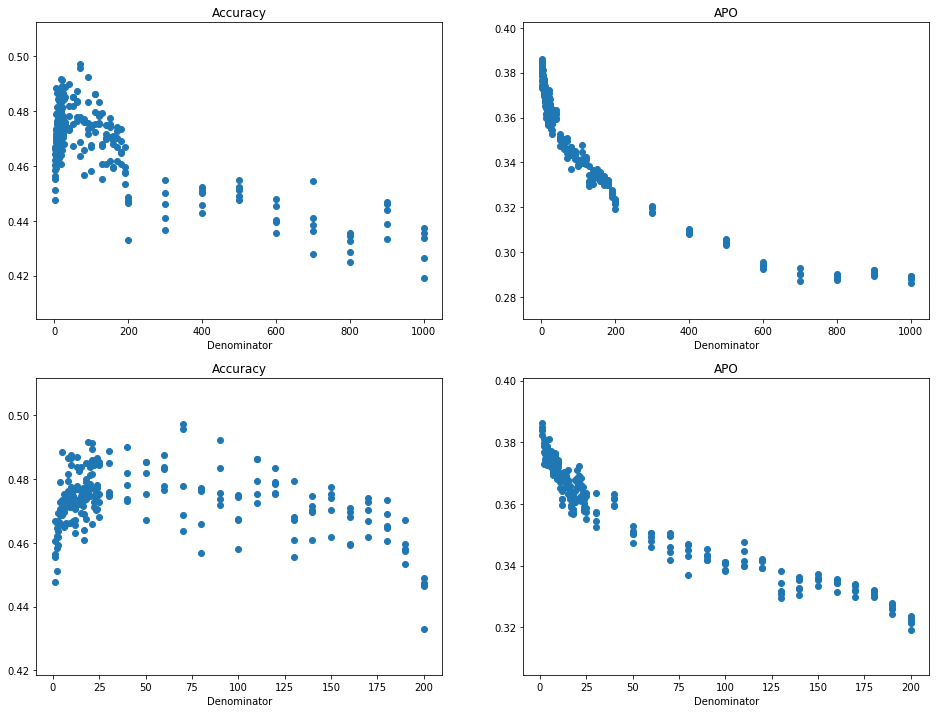

In [11]:
plt.subplots(2, 2, figsize=(16, 12))
plot_info = (('Accuracy', denoms_for_plot, acc), ('APO', denoms_for_plot, apo), ('Accuracy', denoms_for_plot[:215], acc[:215]), ('APO', denoms_for_plot[:215], apo[:215]))
for i in range(len(plot_info)):
    plt.subplot(2, 2, i+1)
    plt.title(plot_info[i][0])
    plt.xlabel('Denominator')
    plt.scatter(plot_info[i][1], plot_info[i][2])
plt.show()

These plots show the results for all 5 trials that were ran for each denominator. Let us plot them again with only the average results.

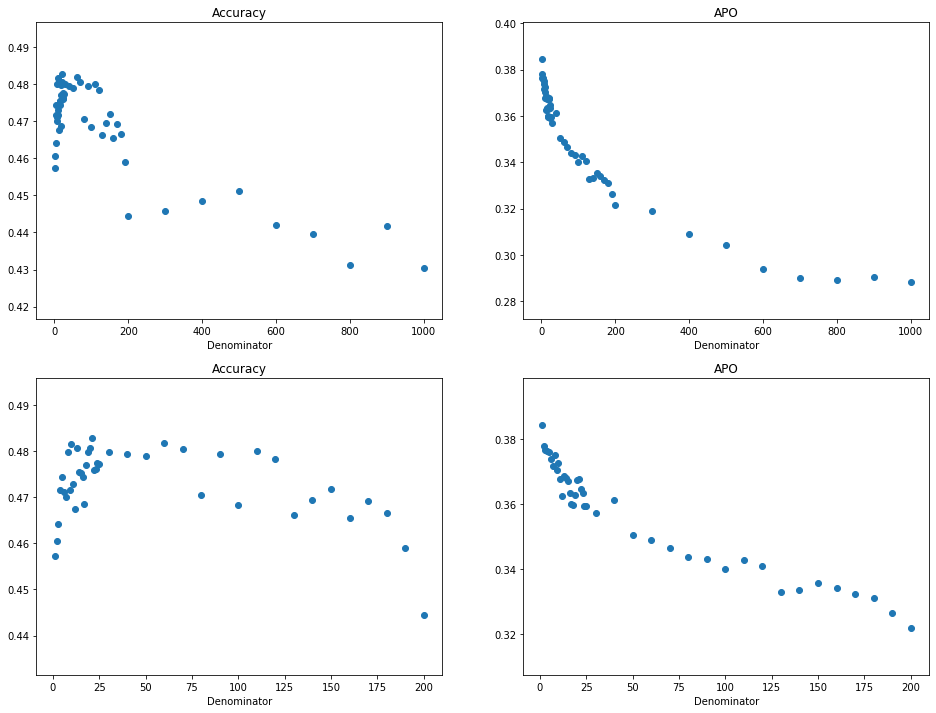

In [18]:
accs = []
apos = []
for i in range(0, len(acc), 5):
    accs.append(average(acc[i:i+5]))
    apos.append(average(apo[i:i+5]))
plt.subplots(2, 2, figsize=(16, 12))
plot_info = (('Accuracy', denoms, accs), ('APO', denoms, apos), ('Accuracy', denoms[:43], accs[:43]), ('APO', denoms[:43], apos[:43]))
for i in range(len(plot_info)):
    plt.subplot(2, 2, i+1)
    plt.title(plot_info[i][0])
    plt.xlabel('Denominator')
    plt.scatter(plot_info[i][1], plot_info[i][2])
plt.show()

From these plots, we see that although the model reaches its highest accuracy with denominators between 20 or 25 and 70, the original HomeZone column leads to the highest APO, which is arguably a more useful and unbiased metric in this case. Note that the results from the HomeZone model are no less accurate than those with the full distance information, confirming that using HomeZones directly may be a promising approach for the Random Forest model.

### Conclusion

It seems that generally, feature engineering and selection has not yielded much value for the distance-related variables. Various approaches remain reasonable: using the standard distance columns, including additional labels or closest distances, or even using zone information directly.

### Next Steps

Some next steps include:

- Tune hyperparameters (tree depth, splitting criterion, etc.)
- Introduce additional variables and perform feature engineering and selection